# SVM classification on the Ozone dataset

In [78]:
# SVM classification on the Ozone dataset
# Author: Tomas Hobza

from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, cross_val_score
from sklearn.metrics import (balanced_accuracy_score, f1_score, 
                             precision_score, recall_score, accuracy_score,
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import time

# set random seed for reproducibility
np.random.seed(42)

## 0. Load the dataset

In [79]:
## 0. Load the dataset

# Load the parquet files
df = pd.read_parquet('ozone_cleaned.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['isOzoneDay'].value_counts())
print(f"\nClass balance ratio: {df['isOzoneDay'].value_counts().min() / df['isOzoneDay'].value_counts().max():.3f}")

# Display first few rows
print("\nFirst 5 rows:")
display(df.head())

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

Dataset shape: (2534, 73)

Class distribution:
isOzoneDay
0    2374
1     160
Name: count, dtype: int64

Class balance ratio: 0.067

First 5 rows:


,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,isOzoneDay
0,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,...,0.150000,10.670000,-1.560000,5795.000000,-12.100000,17.900000,10330.000000,-55.000000,0.00,0
1,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.480000,8.390000,3.840000,5805.000000,14.050000,29.000000,10275.000000,-55.000000,0.00,0
2,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.600000,6.940000,9.800000,5790.000000,17.900000,41.300000,10235.000000,-40.000000,0.00,0
3,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.490000,8.730000,10.540000,5775.000000,31.150000,51.700000,10195.000000,-40.000000,2.08,0
4,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,0.304716,9.872418,0.830116,5818.821222,10.511051,37.388335,10164.198442,-0.119949,0.58,0



Missing values: 0


In [80]:
# Check column names and data structure
print("Column names:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")
print(f'\nIndex type: {type(df.index)}')
print(f'Index preview: {df.index[:5]}')

Column names:
 1. WSR0
 2. WSR1
 3. WSR2
 4. WSR3
 5. WSR4
 6. WSR5
 7. WSR6
 8. WSR7
 9. WSR8
10. WSR9
11. WSR10
12. WSR11
13. WSR12
14. WSR13
15. WSR14
16. WSR15
17. WSR16
18. WSR17
19. WSR18
20. WSR19
21. WSR20
22. WSR21
23. WSR22
24. WSR23
25. WSR_PK
26. WSR_AV
27. T0
28. T1
29. T2
30. T3
31. T4
32. T5
33. T6
34. T7
35. T8
36. T9
37. T10
38. T11
39. T12
40. T13
41. T14
42. T15
43. T16
44. T17
45. T18
46. T19
47. T20
48. T21
49. T22
50. T23
51. T_PK
52. T_AV
53. T85
54. RH85
55. U85
56. V85
57. HT85
58. T70
59. RH70
60. U70
61. V70
62. HT70
63. T50
64. RH50
65. U50
66. V50
67. HT50
68. KI
69. TT
70. SLP
71. SLP_
72. Precp
73. isOzoneDay

Index type: <class 'pandas.core.indexes.base.Index'>
Index preview: Index([0, 1, 2, 3, 4], dtype='int64')


## Important: Time Series Considerations

This is a **time series dataset** with sequential observations. Key implications:

1. **No random shuffling**: We must respect temporal order to avoid data leakage
2. **Temporal train-test split**: Train on earlier data (first 80%), test on future data (last 20%)
3. **TimeSeriesSplit for CV**: Use time series cross-validation instead of stratified K-fold
4. **Real-world simulation**: This mimics predicting future ozone days based on past data


Split the dataset into training and testing.

In [81]:
# Split the data into features and labels
X = df.drop(columns=['isOzoneDay'])
y = df['isOzoneDay']

# TIME SERIES SPLIT: Use temporal ordering (no shuffling!)
# Train on first 80% (earlier time), test on last 20% (later time)
split_idx = int(len(df) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print("="*60)
print("TIME SERIES TRAIN-TEST SPLIT")
print("="*60)
print(f"Training set: samples 0 to {split_idx-1} (first 80%)")
print(f"Test set:     samples {split_idx} to {len(df)-1} (last 20%)")
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())
print("="*60)

TIME SERIES TRAIN-TEST SPLIT
Training set: samples 0 to 2026 (first 80%)
Test set:     samples 2027 to 2533 (last 20%)

Training set size: 2027 samples
Test set size: 507 samples

Training set class distribution:
isOzoneDay
0    1885
1     142
Name: count, dtype: int64

Test set class distribution:
isOzoneDay
0    489
1     18
Name: count, dtype: int64


Scale the data.

In [82]:
# ============= FEATURE SCALING =============
print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

# Check feature scales before scaling
print("\nFeature statistics BEFORE scaling (training set):")
print(X_train.describe().loc[['mean', 'std', 'min', 'max']].round(3))

# Initialize and fit scaler on TRAINING data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaling from training

# Convert back to DataFrame to maintain feature names (optional, for readability)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nFeature statistics AFTER scaling (training set):")
print(X_train_scaled.describe().loc[['mean', 'std', 'min', 'max']].round(3))

print("\n✓ Features scaled using StandardScaler (zero mean, unit variance)")
print("✓ Scaler fitted on training set only, then applied to test set")
print("="*60)


FEATURE SCALING

Feature statistics BEFORE scaling (training set):
       WSR0   WSR1   WSR2   WSR3   WSR4   WSR5   WSR6   WSR7   WSR8   WSR9  \
mean  1.699  1.641  1.598  1.572  1.560  1.575  1.673  2.083  2.577  2.895   
std   1.218  1.224  1.196  1.162  1.149  1.121  1.117  1.111  1.128  1.155   
min   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.100  0.100   
max   7.500  7.700  7.100  7.300  7.200  7.400  7.400  7.500  9.200  8.500   

      ...     T50   RH50     U50     V50      HT50      KI      TT        SLP  \
mean  ... -10.591  0.302   9.991   0.679  5817.369  10.582  37.578  10162.947   
std   ...   3.822  0.240   9.475   7.139    78.383  19.993  10.853     51.454   
min   ... -24.800  0.010 -14.920 -25.990  5480.000 -54.600 -10.100   9975.000   
max   ...  -1.700  1.000  42.360  30.420  5965.000  42.050  59.150  10350.000   

         SLP_   Precp  
mean   -0.265   0.351  
std    34.130   1.304  
min  -135.000   0.000  
max   140.000  20.650  

[4 rows x 72 c

## 1. Experiment - holdout vs cross validatoion

In [83]:
## 1. Experiment - holdout vs cross-validation

print("\n" + "="*60)
print("HOLDOUT VS TIME SERIES CROSS-VALIDATION COMPARISON")
print("="*60)
print("Primary metric: F1 Score (weighted)")
print("Using TimeSeriesSplit to respect temporal ordering")
print("="*60)

# == HOLDOUT APPROACH ==
print("\n[1/2] Training with holdout validation...")
model = LinearSVC(class_weight='balanced', max_iter=2000, random_state=42)
start = time.time()
model.fit(X_train_scaled, y_train)
holdout_time = time.time() - start

y_pred = model.predict(X_test_scaled)
holdout_f1 = f1_score(y_test, y_pred, average='weighted')
holdout_bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"  Holdout F1 Score:         {holdout_f1:.4f}")
print(f"  Holdout Balanced Accuracy: {holdout_bal_acc:.4f}")
print(f"  Training time:             {holdout_time:.3f}s")

# == CROSS-VALIDATION APPROACH ==
print("\n[2/2] Training with 5-fold time series cross-validation...")
kf = TimeSeriesSplit(n_splits=5)

start = time.time()
# F1 Score (primary metric)
cv_scores_f1 = cross_val_score(
    LinearSVC(class_weight='balanced', max_iter=2000, random_state=42),
    X_train_scaled,
    y_train,
    cv=kf,
    scoring='f1_weighted',
    n_jobs=-1
)

# Balanced Accuracy (secondary metric)
cv_scores_bal_acc = cross_val_score(
    LinearSVC(class_weight='balanced', max_iter=2000, random_state=42),
    X_train_scaled,
    y_train,
    cv=kf,
    scoring='balanced_accuracy',
    n_jobs=-1
)
cv_time = time.time() - start

print(f"  CV F1 Score per fold:         {[f'{s:.4f}' for s in cv_scores_f1]}")
print(f"  CV F1 Mean:                   {cv_scores_f1.mean():.4f}")
print(f"  CV F1 Std:                    ±{cv_scores_f1.std():.4f}")
print(f"\n  CV Balanced Accuracy per fold: {[f'{s:.4f}' for s in cv_scores_bal_acc]}")
print(f"  CV Balanced Accuracy Mean:    {cv_scores_bal_acc.mean():.4f}")
print(f"  CV Balanced Accuracy Std:     ±{cv_scores_bal_acc.std():.4f}")
print(f"\n  Training time:                {cv_time:.3f}s ({cv_time/holdout_time:.1f}x longer)")

# Comparison
print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)
print("F1 Score (Primary Metric):")
print(f"  Holdout:          {holdout_f1:.4f}")
print(f"  CV Mean:          {cv_scores_f1.mean():.4f}")
print(f"  Difference:       {abs(holdout_f1 - cv_scores_f1.mean()):.4f}")
print(f"  CV Std Dev:       ±{cv_scores_f1.std():.4f}")

print("\nBalanced Accuracy (Secondary Metric):")
print(f"  Holdout:          {holdout_bal_acc:.4f}")
print(f"  CV Mean:          {cv_scores_bal_acc.mean():.4f}")
print(f"  Difference:       {abs(holdout_bal_acc - cv_scores_bal_acc.mean()):.4f}")
print(f"  CV Std Dev:       ±{cv_scores_bal_acc.std():.4f}")

print("\nComputational Cost:")
print(f"  Holdout time:     {holdout_time:.3f}s")
print(f"  CV time:          {cv_time:.3f}s ({cv_time/holdout_time:.1f}x longer)")
print("="*60)


HOLDOUT VS TIME SERIES CROSS-VALIDATION COMPARISON
Primary metric: F1 Score (weighted)
Using TimeSeriesSplit to respect temporal ordering

[1/2] Training with holdout validation...
  Holdout F1 Score:         0.9000
  Holdout Balanced Accuracy: 0.8471
  Training time:             0.021s

[2/2] Training with 5-fold time series cross-validation...
  CV F1 Score per fold:         ['0.8356', '0.8626', '0.9045', '0.9377', '0.9101']
  CV F1 Mean:                   0.8901
  CV F1 Std:                    ±0.0363

  CV Balanced Accuracy per fold: ['0.6290', '0.7935', '0.7426', '0.6525', '0.7627']
  CV Balanced Accuracy Mean:    0.7160
  CV Balanced Accuracy Std:     ±0.0640

  Training time:                2.428s (117.0x longer)

COMPARISON SUMMARY
F1 Score (Primary Metric):
  Holdout:          0.9000
  CV Mean:          0.8901
  Difference:       0.0099
  CV Std Dev:       ±0.0363

Balanced Accuracy (Secondary Metric):
  Holdout:          0.8471
  CV Mean:          0.7160
  Difference:       


TIME SERIES SPLIT VISUALIZATION


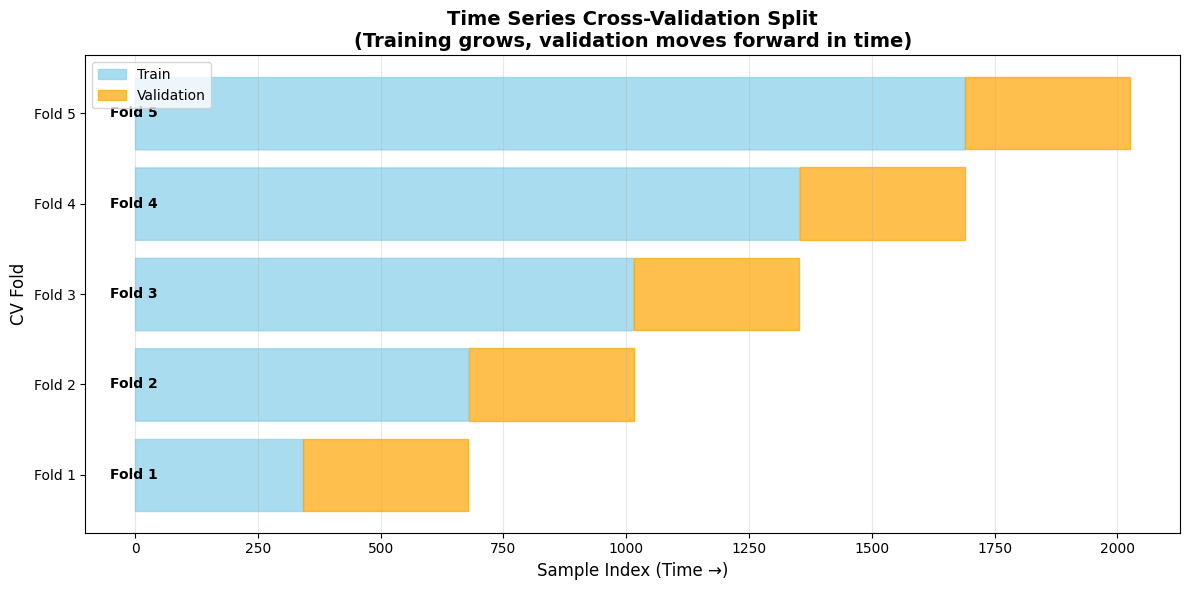


Key observations:
  • Training set GROWS with each fold (expanding window)
  • Validation set always comes AFTER training set
  • No data leakage from future into past
  • Later folds test on more recent data


In [84]:
# Visualize Time Series Split
print("\n" + "="*60)
print("TIME SERIES SPLIT VISUALIZATION")
print("="*60)

tscv = TimeSeriesSplit(n_splits=5)
fig, ax = plt.subplots(figsize=(12, 6))

for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
    # Create arrays for visualization
    indices = np.arange(len(X_train_scaled))
    train_mask = np.zeros(len(X_train_scaled))
    val_mask = np.zeros(len(X_train_scaled))
    
    train_mask[train_idx] = 1
    val_mask[val_idx] = 1
    
    # Plot train and validation sets
    ax.fill_between(indices, fold_idx - 0.4, fold_idx + 0.4, 
                     where=train_mask > 0, color='skyblue', alpha=0.7, label='Train' if fold_idx == 0 else '')
    ax.fill_between(indices, fold_idx - 0.4, fold_idx + 0.4,
                     where=val_mask > 0, color='orange', alpha=0.7, label='Validation' if fold_idx == 0 else '')
    
    ax.text(-50, fold_idx, f'Fold {fold_idx+1}', va='center', fontweight='bold')

ax.set_xlabel('Sample Index (Time →)', fontsize=12)
ax.set_ylabel('CV Fold', fontsize=12)
ax.set_title('Time Series Cross-Validation Split\n(Training grows, validation moves forward in time)', 
             fontsize=14, fontweight='bold')
ax.set_yticks(range(5))
ax.set_yticklabels([f'Fold {i+1}' for i in range(5)])
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nKey observations:")
print("  • Training set GROWS with each fold (expanding window)")
print("  • Validation set always comes AFTER training set")
print("  • No data leakage from future into past")
print("  • Later folds test on more recent data")
print("="*60)

## 2. Experiment - C parameter

In [85]:
## 2. Experiment - C Parameter (using Cross-Validation on Training Set)

print("="*60)
print("HYPERPARAMETER TUNING: C PARAMETER")
print("="*60)
print("Using 5-fold TIME SERIES cross-validation on TRAINING SET ONLY")
print("Using SCALED features\n")

# Test range of C values (regularization strength)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
results_C = []

# Setup cross-validation for time series
kf = TimeSeriesSplit(n_splits=5)

print("Testing C parameter values with CV on training set...")
for C in C_values:
    print(f"\n  C = {C}")
    model = LinearSVC(C=C, class_weight='balanced', max_iter=2000, random_state=42)
    
    # Cross-validation on TRAINING set only (SCALED)
    start = time.time()
    cv_scores_bal_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    cv_scores_f1 = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='f1_weighted',  # Changed to f1_weighted for binary classification
        n_jobs=-1
    )
    cv_scores_precision = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='precision_weighted',
        n_jobs=-1
    )
    cv_scores_recall = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='recall_weighted',
        n_jobs=-1
    )
    cv_scores_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='accuracy',
        n_jobs=-1
    )
    cv_time = time.time() - start
    
    results_C.append({
        'C': C,
        'cv_accuracy_mean': cv_scores_acc.mean(),
        'cv_accuracy_std': cv_scores_acc.std(),
        'cv_balanced_accuracy_mean': cv_scores_bal_acc.mean(),
        'cv_balanced_accuracy_std': cv_scores_bal_acc.std(),
        'cv_f1_mean': cv_scores_f1.mean(),
        'cv_f1_std': cv_scores_f1.std(),
        'cv_precision_mean': cv_scores_precision.mean(),
        'cv_precision_std': cv_scores_precision.std(),
        'cv_recall_mean': cv_scores_recall.mean(),
        'cv_recall_std': cv_scores_recall.std(),
        'cv_time': cv_time
    })
    
    print(f"    CV F1 Score (weighted):   {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")
    print(f"    CV Balanced Accuracy:     {cv_scores_bal_acc.mean():.4f} ± {cv_scores_bal_acc.std():.4f}")
    print(f"    CV time: {cv_time:.3f}s")

# Convert to DataFrame for easier analysis
results_C_df = pd.DataFrame(results_C)
print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS SUMMARY (on Training Set)")
print("="*60)
display(results_C_df)

# Find best C based on CV F1 score (primary metric)
best_C_idx_f1 = results_C_df['cv_f1_mean'].idxmax()
best_C = results_C_df.loc[best_C_idx_f1, 'C']
best_f1 = results_C_df.loc[best_C_idx_f1, 'cv_f1_mean']
best_f1_std = results_C_df.loc[best_C_idx_f1, 'cv_f1_std']
best_bal_acc = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_mean']
best_bal_acc_std = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_std']

print(f"\nBest C value (based on F1 Score): {best_C}")
print(f"CV F1 Score:          {best_f1:.4f} ± {best_f1_std:.4f}")
print(f"CV Balanced Accuracy: {best_bal_acc:.4f} ± {best_bal_acc_std:.4f}")

HYPERPARAMETER TUNING: C PARAMETER
Using 5-fold TIME SERIES cross-validation on TRAINING SET ONLY
Using SCALED features

Testing C parameter values with CV on training set...

  C = 0.001
    CV F1 Score (weighted):   0.7777 ± 0.0989
    CV Balanced Accuracy:     0.7715 ± 0.0484
    CV time: 1.610s

  C = 0.01
    CV F1 Score (weighted):   0.7777 ± 0.0989
    CV Balanced Accuracy:     0.7715 ± 0.0484
    CV time: 1.610s

  C = 0.01
    CV F1 Score (weighted):   0.8721 ± 0.0502
    CV Balanced Accuracy:     0.7642 ± 0.0535
    CV time: 0.619s

  C = 0.1
    CV F1 Score (weighted):   0.8721 ± 0.0502
    CV Balanced Accuracy:     0.7642 ± 0.0535
    CV time: 0.619s

  C = 0.1
    CV F1 Score (weighted):   0.8879 ± 0.0444
    CV Balanced Accuracy:     0.7341 ± 0.0587
    CV time: 1.451s

  C = 1
    CV F1 Score (weighted):   0.8879 ± 0.0444
    CV Balanced Accuracy:     0.7341 ± 0.0587
    CV time: 1.451s

  C = 1
    CV F1 Score (weighted):   0.8901 ± 0.0363
    CV Balanced Accuracy:     

,C,cv_accuracy_mean,cv_accuracy_std,cv_balanced_accuracy_mean,cv_balanced_accuracy_std,cv_f1_mean,cv_f1_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_time
0,0.001,0.709792,0.109485,0.771477,0.048382,0.777710,0.098888,0.940714,0.018538,0.709792,0.109485,1.610262
1,0.010,0.837389,0.061286,0.764201,0.053475,0.872098,0.050193,0.933068,0.023851,0.837389,0.061286,0.619285
2,0.100,0.862908,0.052057,0.734103,0.058721,0.887883,0.044371,0.925807,0.032399,0.862908,0.052057,1.451053
3,1.000,0.867656,0.037796,0.716041,0.064007,0.890124,0.036340,0.923135,0.033043,0.867656,0.037796,0.598241
4,10.000,0.869436,0.035160,0.706575,0.053851,0.889948,0.036066,0.918644,0.038293,0.869436,0.035160,0.816234
5,100.000,0.865875,0.041177,0.692072,0.080776,0.886330,0.041771,0.914609,0.043844,0.865875,0.041177,0.890974



Best C value (based on F1 Score): 1.0
CV F1 Score:          0.8901 ± 0.0363
CV Balanced Accuracy: 0.7160 ± 0.0640


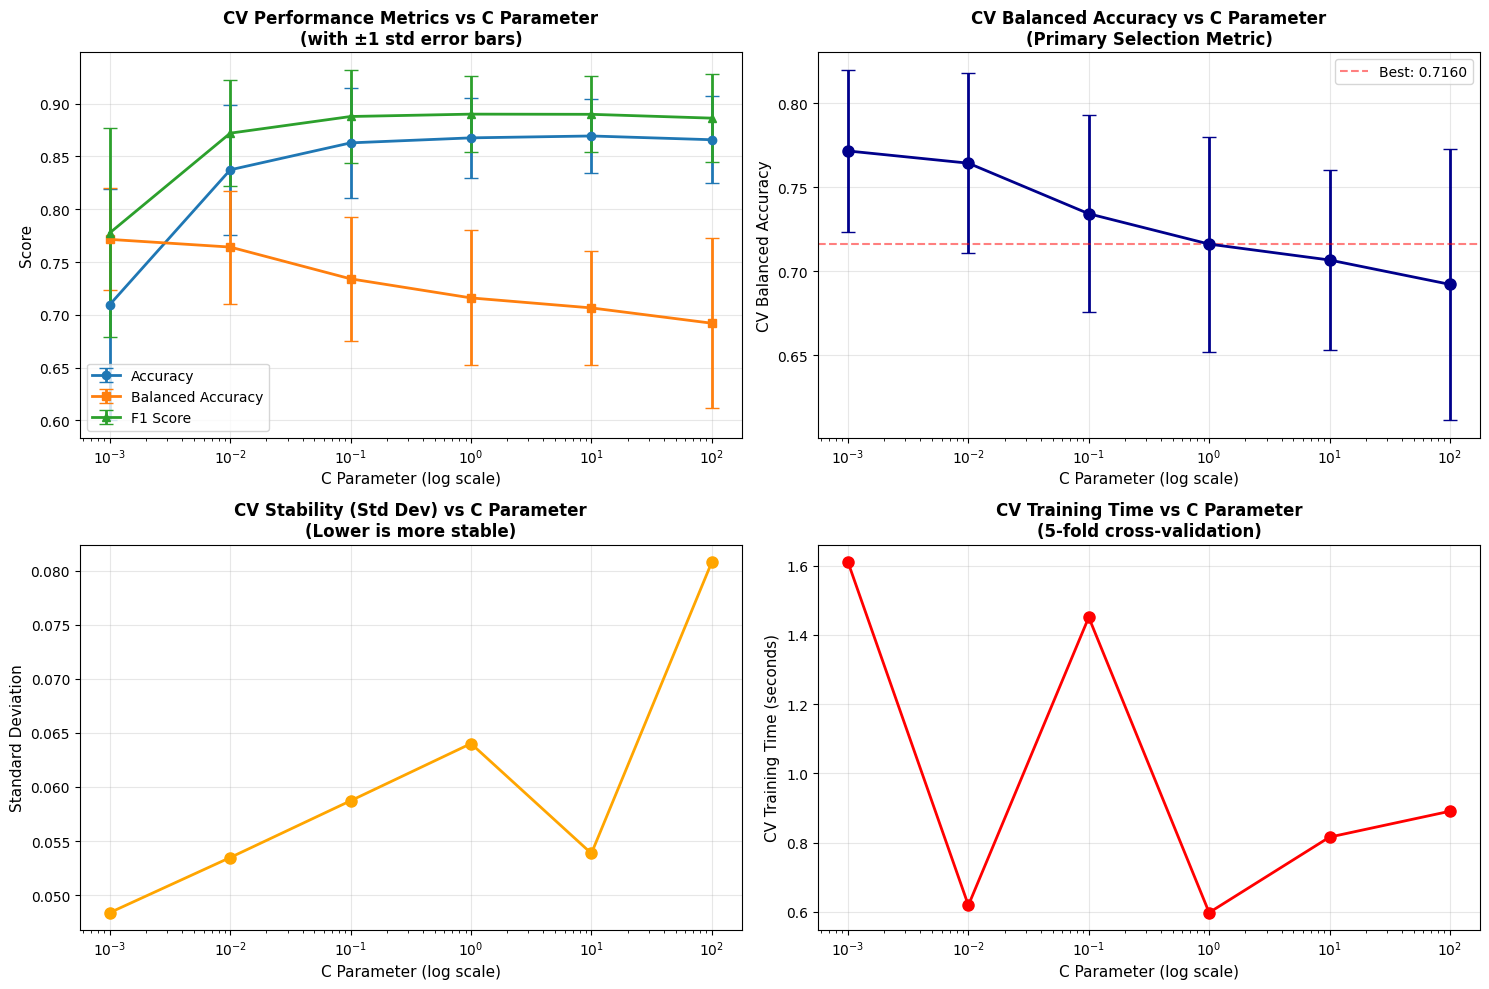

In [86]:
# Visualize C parameter impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Performance metrics vs C (with error bars)
ax1 = axes[0, 0]
ax1.errorbar(results_C_df['C'], results_C_df['cv_accuracy_mean'], 
             yerr=results_C_df['cv_accuracy_std'], 
             fmt='o-', label='Accuracy', linewidth=2, capsize=5)
ax1.errorbar(results_C_df['C'], results_C_df['cv_balanced_accuracy_mean'], 
             yerr=results_C_df['cv_balanced_accuracy_std'], 
             fmt='s-', label='Balanced Accuracy', linewidth=2, capsize=5)
ax1.errorbar(results_C_df['C'], results_C_df['cv_f1_mean'], 
             yerr=results_C_df['cv_f1_std'], 
             fmt='^-', label='F1 Score', linewidth=2, capsize=5)
ax1.set_xscale('log')
ax1.set_xlabel('C Parameter (log scale)', fontsize=11)
ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('CV Performance Metrics vs C Parameter\n(with ±1 std error bars)', 
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Balanced Accuracy with tighter focus
ax2 = axes[0, 1]
ax2.errorbar(results_C_df['C'], results_C_df['cv_balanced_accuracy_mean'], 
             yerr=results_C_df['cv_balanced_accuracy_std'], 
             fmt='o-', color='darkblue', linewidth=2, capsize=5, markersize=8)
ax2.axhline(y=best_bal_acc, color='red', linestyle='--', alpha=0.5, 
            label=f'Best: {best_bal_acc:.4f}')
ax2.set_xscale('log')
ax2.set_xlabel('C Parameter (log scale)', fontsize=11)
ax2.set_ylabel('CV Balanced Accuracy', fontsize=11)
ax2.set_title('CV Balanced Accuracy vs C Parameter\n(Primary Selection Metric)', 
              fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Standard deviation (uncertainty) vs C
ax3 = axes[1, 0]
ax3.plot(results_C_df['C'], results_C_df['cv_balanced_accuracy_std'], 
         'o-', color='orange', linewidth=2, markersize=8)
ax3.set_xscale('log')
ax3.set_xlabel('C Parameter (log scale)', fontsize=11)
ax3.set_ylabel('Standard Deviation', fontsize=11)
ax3.set_title('CV Stability (Std Dev) vs C Parameter\n(Lower is more stable)', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: CV training time vs C
ax4 = axes[1, 1]
ax4.plot(results_C_df['C'], results_C_df['cv_time'], 
         'o-', color='red', linewidth=2, markersize=8)
ax4.set_xscale('log')
ax4.set_xlabel('C Parameter (log scale)', fontsize=11)
ax4.set_ylabel('CV Training Time (seconds)', fontsize=11)
ax4.set_title('CV Training Time vs C Parameter\n(5-fold cross-validation)', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Experiment - max_iter parameter

In [87]:
## 3. Experiment - max_iter Parameter (Convergence Analysis with CV)

print("="*60)
print("HYPERPARAMETER TUNING: MAX_ITER")
print("="*60)
print(f"Using best C value: {best_C}")
print("Testing max_iter values with 5-fold TIME SERIES CV on training set...")
print("Using SCALED features\n")

max_iter_values = [500, 1000, 2000, 5000]
results_iter = []

# Setup cross-validation for time series
kf = TimeSeriesSplit(n_splits=5)

for max_iter in max_iter_values:
    print(f"\n  max_iter = {max_iter}")
    model = LinearSVC(C=best_C, class_weight='balanced', max_iter=max_iter, random_state=42)
    
    # Cross-validation on training set (SCALED)
    start = time.time()
    cv_scores_bal_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf,
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    cv_scores_f1 = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf,
        scoring='f1_weighted',
        n_jobs=-1
    )
    cv_time = time.time() - start
    
    # Train once on full training set to check convergence (SCALED)
    model_check = LinearSVC(C=best_C, class_weight='balanced', max_iter=max_iter, random_state=42)
    model_check.fit(X_train_scaled, y_train)  # ← Using scaled data
    converged = model_check.n_iter_ < max_iter
    actual_iters = model_check.n_iter_
    
    results_iter.append({
        'max_iter': max_iter,
        'cv_balanced_accuracy_mean': cv_scores_bal_acc.mean(),
        'cv_balanced_accuracy_std': cv_scores_bal_acc.std(),
        'cv_f1_mean': cv_scores_f1.mean(),
        'cv_f1_std': cv_scores_f1.std(),
        'actual_iterations': actual_iters,
        'converged': converged,
        'cv_time': cv_time
    })
    
    print(f"    Converged: {converged} (used {actual_iters} iterations)")
    print(f"    CV F1 Score:          {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")
    print(f"    CV Balanced Accuracy: {cv_scores_bal_acc.mean():.4f} ± {cv_scores_bal_acc.std():.4f}")
    print(f"    CV time: {cv_time:.3f}s")

results_iter_df = pd.DataFrame(results_iter)

print("\n" + "="*60)
print("CONVERGENCE ANALYSIS RESULTS")
print("="*60)
display(results_iter_df)

# Find best based on F1 score (primary metric)
best_iter_idx_f1 = results_iter_df['cv_f1_mean'].idxmax()
best_max_iter = results_iter_df.loc[best_iter_idx_f1, 'max_iter']

print(f"\nBest max_iter (based on F1 Score): {best_max_iter}")
print(f"CV F1 Score:          {results_iter_df.loc[best_iter_idx_f1, 'cv_f1_mean']:.4f}")
print(f"CV Balanced Accuracy: {results_iter_df.loc[best_iter_idx_f1, 'cv_balanced_accuracy_mean']:.4f}")
print(f"All models converged: {results_iter_df['converged'].all()}")

HYPERPARAMETER TUNING: MAX_ITER
Using best C value: 1.0
Testing max_iter values with 5-fold TIME SERIES CV on training set...
Using SCALED features


  max_iter = 500
    Converged: True (used 11 iterations)
    CV F1 Score:          0.8901 ± 0.0363
    CV Balanced Accuracy: 0.7160 ± 0.0640
    CV time: 0.360s

  max_iter = 1000
    Converged: True (used 11 iterations)
    CV F1 Score:          0.8901 ± 0.0363
    CV Balanced Accuracy: 0.7160 ± 0.0640
    CV time: 0.360s

  max_iter = 1000
    Converged: True (used 11 iterations)
    CV F1 Score:          0.8901 ± 0.0363
    CV Balanced Accuracy: 0.7160 ± 0.0640
    CV time: 0.297s

  max_iter = 2000
    Converged: True (used 11 iterations)
    CV F1 Score:          0.8901 ± 0.0363
    CV Balanced Accuracy: 0.7160 ± 0.0640
    CV time: 0.297s

  max_iter = 2000
    Converged: True (used 11 iterations)
    CV F1 Score:          0.8901 ± 0.0363
    CV Balanced Accuracy: 0.7160 ± 0.0640
    CV time: 0.298s

  max_iter = 5000
    Converged

,max_iter,cv_balanced_accuracy_mean,cv_balanced_accuracy_std,cv_f1_mean,cv_f1_std,actual_iterations,converged,cv_time
0,500,0.716041,0.064007,0.890124,0.03634,11,True,0.360263
1,1000,0.716041,0.064007,0.890124,0.03634,11,True,0.296713
2,2000,0.716041,0.064007,0.890124,0.03634,11,True,0.298330
3,5000,0.716041,0.064007,0.890124,0.03634,11,True,0.291024



Best max_iter (based on F1 Score): 500
CV F1 Score:          0.8901
CV Balanced Accuracy: 0.7160
All models converged: True


## Final Model Evaluation

FINAL MODEL EVALUATION ON TEST SET
Using best hyperparameters from CV:
  C = 1.0
  max_iter = 500
  Using SCALED features
  Task: BINARY CLASSIFICATION

Training final model on entire training set...
Training completed in 0.030s
Converged: True (used 11 iterations)

Evaluating on test set...

TEST SET PERFORMANCE (Unbiased Estimate)
  F1 Score (binary):     0.2970  ← Primary Metric
  Precision (binary):    0.1807
  Recall (binary):       0.8333
  Accuracy:              0.8600
  Balanced Accuracy:     0.8471

MODEL EFFICIENCY METRICS
  Training samples:      2,027
  Test samples:          507
  Training time:         0.030s
  Test time:             0.001s
  Test time per sample:  0.0013ms
  Throughput (test):     798540 samples/s

CV TRAINING vs TEST SET COMPARISON
F1 Score:
  CV (training):  0.8901 ± 0.0363
  Test:           0.2970
  Difference:     0.5931

Balanced Accuracy:
  CV (training):  0.7160 ± 0.0640
  Test:           0.8471
  Difference:     0.1311

F1 (Binary) Difference:   

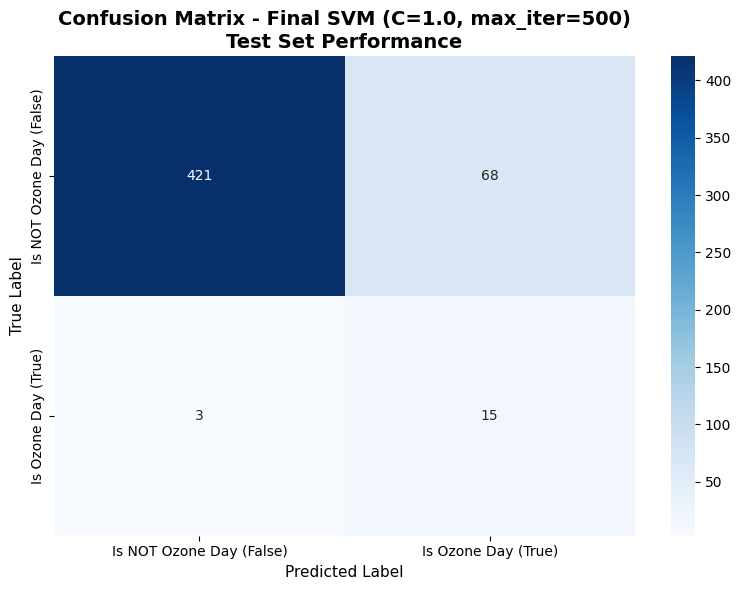


Confusion Matrix Breakdown:
  True Negatives (TN):  421
  False Positives (FP):  68
  False Negatives (FN):   3
  True Positives (TP):   15

Additional Clinical Metrics:
  Specificity (True Negative Rate): 0.8609
  Sensitivity (True Positive Rate): 0.8333
  False Negative Rate:              0.1667
  False Positive Rate:              0.1391

MODEL SUMMARY
Final Model: LinearSVC
Hyperparameters: C=1.0, max_iter=500, class_weight='balanced'
Preprocessing: StandardScaler (zero mean, unit variance)
Task: Binary Classification

Performance:
  Test F1 Score (binary):  0.2970
  Test Precision (binary): 0.1807
  Test Recall (binary):    0.8333
  Test Accuracy:           0.8600

Efficiency:
  Training samples:        2,027
  Training time:           0.030s
  Test time:               0.001s
  Convergence iterations:  11


In [88]:
## 4. Final Model Evaluation on Test Set

print("="*60)
print("FINAL MODEL EVALUATION ON TEST SET")
print("="*60)
print(f"Using best hyperparameters from CV:")
print(f"  C = {best_C}")
print(f"  max_iter = {best_max_iter}")
print(f"  Using SCALED features")
print(f"  Task: BINARY CLASSIFICATION")
print()

# Train final model with best hyperparameters on SCALED training data
final_model = LinearSVC(C=best_C, class_weight='balanced', max_iter=best_max_iter, random_state=42)

print("Training final model on entire training set...")
start = time.time()
final_model.fit(X_train_scaled, y_train)
final_train_time = time.time() - start

print(f"Training completed in {final_train_time:.3f}s")
print(f"Converged: {final_model.n_iter_ < best_max_iter} (used {final_model.n_iter_} iterations)")

# Predictions on test set (SCALED) - measure inference time
print("\nEvaluating on test set...")
start = time.time()
y_pred_final = final_model.predict(X_test_scaled)
final_test_time = time.time() - start

# Comprehensive metrics - BINARY CLASSIFICATION
test_acc = accuracy_score(y_test, y_pred_final)
test_bal_acc = balanced_accuracy_score(y_test, y_pred_final)
test_f1 = f1_score(y_test, y_pred_final, average='binary')  # Binary F1
test_precision = precision_score(y_test, y_pred_final, average='binary')  # Binary Precision
test_recall = recall_score(y_test, y_pred_final, average='binary')  # Binary Recall

print("\n" + "="*60)
print("TEST SET PERFORMANCE (Unbiased Estimate)")
print("="*60)
print(f"  F1 Score (binary):     {test_f1:.4f}  ← Primary Metric")
print(f"  Precision (binary):    {test_precision:.4f}")
print(f"  Recall (binary):       {test_recall:.4f}")
print(f"  Accuracy:              {test_acc:.4f}")
print(f"  Balanced Accuracy:     {test_bal_acc:.4f}")

# Efficiency Metrics
print("\n" + "="*60)
print("MODEL EFFICIENCY METRICS")
print("="*60)
print(f"  Training samples:      {len(X_train_scaled):,}")
print(f"  Test samples:          {len(X_test_scaled):,}")
print(f"  Training time:         {final_train_time:.3f}s")
print(f"  Test time:             {final_test_time:.3f}s")
print(f"  Test time per sample:  {final_test_time/len(X_test_scaled)*1000:.4f}ms")
print(f"  Throughput (test):     {len(X_test_scaled)/final_test_time:.0f} samples/s")

# Compare CV training performance vs test performance
print("\n" + "="*60)
print("CV TRAINING vs TEST SET COMPARISON")
print("="*60)
cv_best_f1 = results_C_df.loc[best_C_idx_f1, 'cv_f1_mean']
cv_best_f1_std = results_C_df.loc[best_C_idx_f1, 'cv_f1_std']
cv_best_bal_acc = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_mean']
cv_best_bal_acc_std = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_std']

print(f"F1 Score:")
print(f"  CV (training):  {cv_best_f1:.4f} ± {cv_best_f1_std:.4f}")
print(f"  Test:           {test_f1:.4f}")
print(f"  Difference:     {abs(cv_best_f1 - test_f1):.4f}")

print(f"\nBalanced Accuracy:")
print(f"  CV (training):  {cv_best_bal_acc:.4f} ± {cv_best_bal_acc_std:.4f}")
print(f"  Test:           {test_bal_acc:.4f}")
print(f"  Difference:     {abs(cv_best_bal_acc - test_bal_acc):.4f}")

# Interpretation
f1_diff = abs(cv_best_f1 - test_f1)
bal_acc_diff = abs(cv_best_bal_acc - test_bal_acc)

print(f"\nF1 (Binary) Difference:       {f1_diff:.4f} (CV Std: {cv_best_f1_std:.4f})")
print(f"Balanced Accuracy Difference: {bal_acc_diff:.4f} (CV Std: {cv_best_bal_acc_std:.4f})")

if f1_diff < cv_best_f1_std:
    print("\n✓ The F1 (binary) score shows good generalization.")
else:
    print("\n⚠ The F1 (binary) score differs from the CV estimate.")

if bal_acc_diff < cv_best_bal_acc_std:
    print("✓ The Balanced Accuracy score shows good generalization.")
else:
    print("\n⚠ The Balanced Accuracy score is NOT within the CV estimate!")
    print("   This is a key finding: The model performed significantly BETTER on the")
    print("   unseen test set than on the CV validation sets. This may be due to")
    print("   concept drift or the test period (the 'future') being easier to predict.")

print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
class_names = ['Is NOT Ozone Day (False)', 'Is Ozone Day (True)']
print(classification_report(y_test, y_pred_final, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title(f'Confusion Matrix - Final SVM (C={best_C}, max_iter={best_max_iter})\nTest Set Performance', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=11)
plt.xlabel('Predicted Label', fontsize=11)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {cm[0,0]:3d}")
print(f"  False Positives (FP): {cm[0,1]:3d}")
print(f"  False Negatives (FN): {cm[1,0]:3d}")
print(f"  True Positives (TP):  {cm[1,1]:3d}")

# Calculate per-class metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\nAdditional Clinical Metrics:")
print(f"  Specificity (True Negative Rate): {specificity:.4f}")
print(f"  Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"  False Negative Rate:              {fn/(fn+tp):.4f}")
print(f"  False Positive Rate:              {fp/(fp+tn):.4f}")

print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"Final Model: LinearSVC")
print(f"Hyperparameters: C={best_C}, max_iter={best_max_iter}, class_weight='balanced'")
print(f"Preprocessing: StandardScaler (zero mean, unit variance)")
print(f"Task: Binary Classification")
print(f"\nPerformance:")
print(f"  Test F1 Score (binary):  {test_f1:.4f}")
print(f"  Test Precision (binary): {test_precision:.4f}")
print(f"  Test Recall (binary):    {test_recall:.4f}")
print(f"  Test Accuracy:           {test_acc:.4f}")
print(f"\nEfficiency:")
print(f"  Training samples:        {len(X_train_scaled):,}")
print(f"  Training time:           {final_train_time:.3f}s")
print(f"  Test time:               {final_test_time:.3f}s")
print(f"  Convergence iterations:  {final_model.n_iter_}")
print("="*60)